<a href="https://colab.research.google.com/github/AubLambert/FraudDetection/blob/quang/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
!pip install catplot

# Basic Analysis

## Import Data

In [4]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Optional: Set the width to avoid line breaks
pd.set_option('display.width', None)

df = pd.read_csv('fraudTrain.csv', on_bad_lines='warn')  # or 'skip' or 'error'
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654.0,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160.0,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252.0,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632.0,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433.0,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895084,895084,2019-12-25 14:36:10,213174467670432,"fraud_Schiller, Blanda and Johnson",home,30.23,James,Bishop,M,7055 Fernandez Estates Apt. 676,Cecilton,MD,21913.0,39.4015,-75.8654,663.0,Podiatrist,1969-01-14,7f8ace7d126cc3687fb5e399487e6532,1.356446e+09,40.371404,-75.280860,0.0
895085,895085,2019-12-25 14:36:14,4989847570577635369,"fraud_Armstrong, Walter and Gottlieb",food_dining,26.30,Vanessa,Anderson,F,21178 Brittney Locks,Prosperity,SC,29127.0,34.1832,-81.5324,8333.0,Archaeologist,1994-07-09,d920c9fad3f4c1cff612026bc5e9470b,1.356446e+09,33.363949,-80.603823,0.0
895086,895086,2019-12-25 14:36:21,38947654498698,fraud_Bode-Rempel,kids_pets,7.54,Lori,Rodriguez,F,12087 Michael Light,Creola,OH,45622.0,39.3543,-82.5030,321.0,"Copywriter, advertising",1979-06-24,6ceae4cc2dfe785533f8432b32d7d655,1.356446e+09,38.833550,-81.687636,0.0
895087,895087,2019-12-25 14:36:56,3545109339866548,fraud_Brown-Greenholt,entertainment,60.01,Keith,Sanders,M,8030 Beck Motorway,Moorhead,MS,38761.0,33.4783,-90.5142,2870.0,Chartered public finance accountant,1999-03-05,d83cda576e8ca8186cd7e792b931223a,1.356446e+09,33.015147,-91.007380,0.0


In [7]:
df = df.drop('Unnamed: 0', axis=1)

# Descriptive Statistics

In [8]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,8.950890e+05,895089.000000,895088.000000,895088.000000,895088.000000,8.950880e+05,8.950880e+05,895088.000000,895088.000000,895088.000000
mean,4.167009e+17,70.273570,48791.882349,38.533871,-90.223112,8.913355e+04,1.342411e+09,38.533739,-90.223269,0.005670
std,1.308244e+18,162.208387,26903.555438,5.075635,13.764958,3.026086e+05,8.862448e+06,5.109913,13.777014,0.075085
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325376e+09,19.027785,-166.671242,0.000000
25%,1.800400e+14,9.640000,26237.000000,34.668900,-96.798000,7.430000e+02,1.335134e+09,34.735193,-96.898416,0.000000
50%,3.520550e+15,47.410000,48174.000000,39.354300,-87.476900,2.456000e+03,1.342595e+09,39.363662,-87.432501,0.000000
75%,4.642255e+15,83.050000,72011.000000,41.894800,-80.158000,2.047800e+04,1.350126e+09,41.952929,-80.226742,0.000000
max,4.992346e+18,28948.900000,99783.000000,66.693300,-67.950300,2.906700e+06,1.356446e+09,67.510267,-66.956540,1.000000


In [9]:
df.shape

(895089, 22)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895089 entries, 0 to 895088
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  895089 non-null  object 
 1   cc_num                 895089 non-null  int64  
 2   merchant               895089 non-null  object 
 3   category               895089 non-null  object 
 4   amt                    895089 non-null  float64
 5   first                  895089 non-null  object 
 6   last                   895088 non-null  object 
 7   gender                 895088 non-null  object 
 8   street                 895088 non-null  object 
 9   city                   895088 non-null  object 
 10  state                  895088 non-null  object 
 11  zip                    895088 non-null  float64
 12  lat                    895088 non-null  float64
 13  long                   895088 non-null  float64
 14  city_pop               895088 non-nu

In [14]:
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [13]:
df.dropna(inplace=True)

In [12]:
df.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,959
amt,45685
zip,946
lat,944
long,945
city_pop,861
unix_time,879549
merch_lat,871650
merch_long,885092
is_fraud,2


In [15]:
df.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,879517
merchant,693
category,14
first,346
last,476
gender,2
street,959
city,876
state,51
job,492


# EDA

In [16]:
# Create a copy for EDA
df_viz = df.copy()

## Fraud Distribution

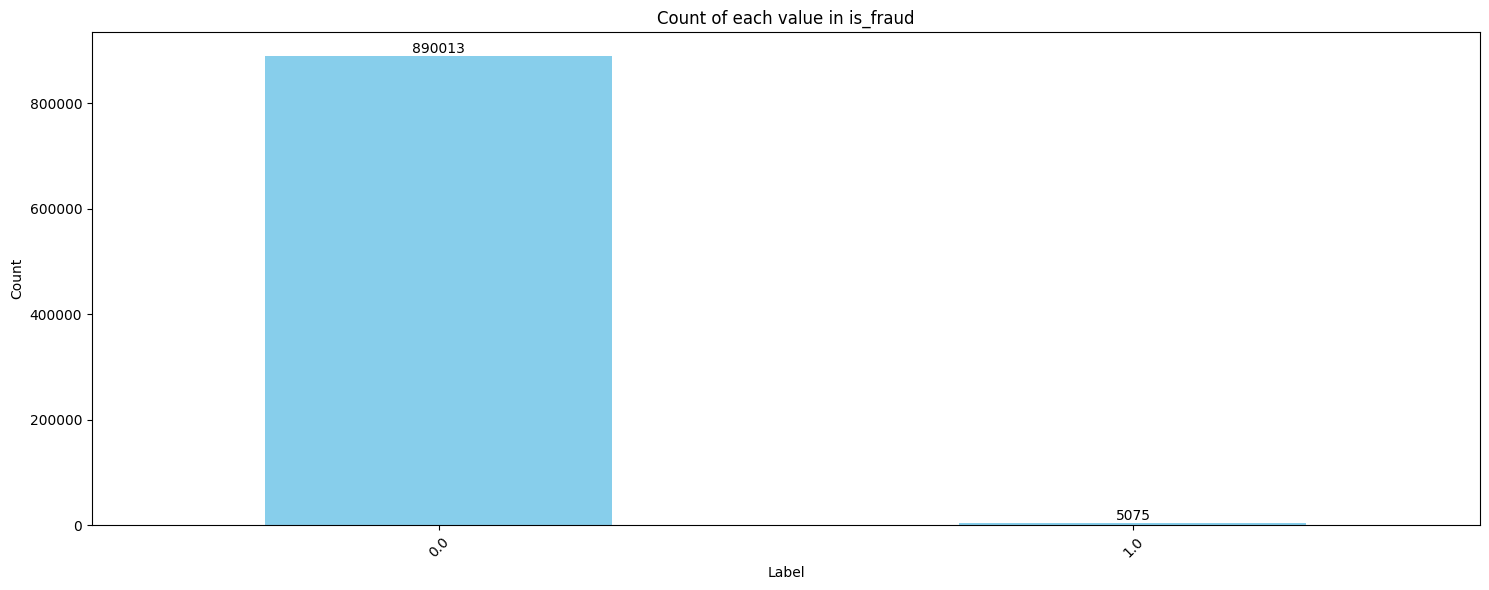

In [17]:
def cat_plot(df, column):
    counts = df[column].value_counts()

    plt.figure(figsize=(15, 6))
    ax = counts.plot(kind='bar', color='skyblue')

    # Add labels on top of bars
    for i, v in enumerate(counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

    plt.title(f"Count of each value in {column}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

cat_plot(df_viz, "is_fraud")

In [18]:
fraud_percent = (df['is_fraud'] == 1).sum()/(df.shape[0])

print(f"Fraud Percentage: {fraud_percent * 100:.5f}%")

Fraud Percentage: 0.56698%


## Date and Time Heatmap


### Transaction

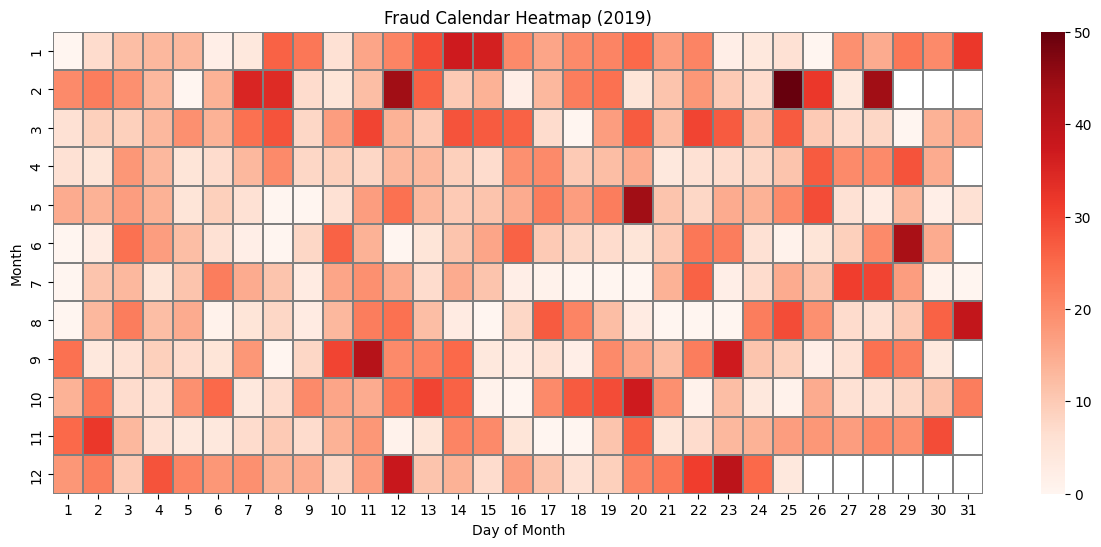

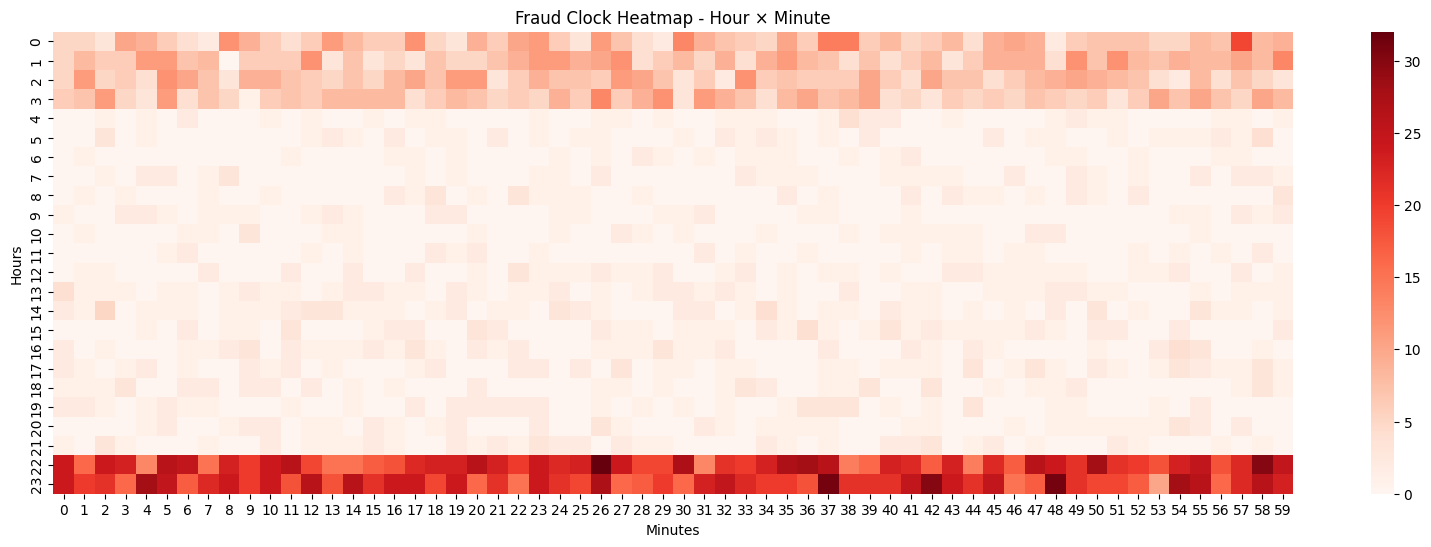

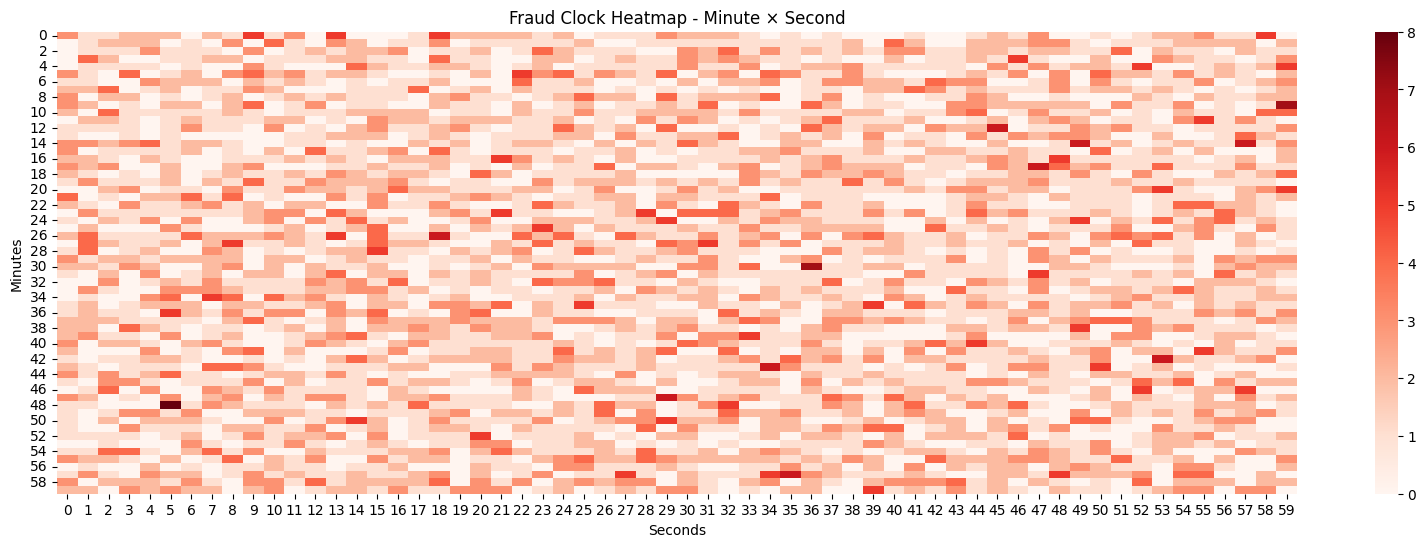

In [19]:
df_viz["trans_date_trans_time"] = pd.to_datetime(df_viz["trans_date_trans_time"])
df_viz["year"] = df_viz["trans_date_trans_time"].dt.year
df_viz["month"] = df_viz["trans_date_trans_time"].dt.month
df_viz["day"] = df_viz["trans_date_trans_time"].dt.day
df_viz["hour"] = df_viz["trans_date_trans_time"].dt.hour
df_viz["minute"] = df_viz["trans_date_trans_time"].dt.minute
df_viz["second"] = df_viz["trans_date_trans_time"].dt.second

# =====================================================
# 1) CALENDAR HEATMAP (Year × Month × Day)
# =====================================================
fraud_calendar = df_viz.groupby(["year","month","day"])["is_fraud"].sum().reset_index()

for yr in sorted(fraud_calendar["year"].unique()):
    pivoted = fraud_calendar[fraud_calendar["year"]==yr].pivot(
        index="month", columns="day", values="is_fraud"
    )

    plt.figure(figsize=(15,6))
    sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
    plt.title(f"Fraud Calendar Heatmap ({yr})")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.show()

# =====================================================
# 2) CLOCK HEATMAP (Hour × Minute)
# =====================================================

fraud_clock_min = df_viz.groupby(["hour","minute"])["is_fraud"].sum().reset_index()

pivoted_clock_min = fraud_clock_min.pivot_table(
    index="hour", columns="minute", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_min, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Hour × Minute")
plt.xlabel("Minutes")
plt.ylabel("Hours")
plt.show()

fraud_clock_sec = df_viz.groupby(["minute","second"])["is_fraud"].sum().reset_index()

pivoted_clock_sec = fraud_clock_sec.pivot_table(
    index="minute", columns="second", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_sec, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Minute × Second")
plt.xlabel("Seconds")
plt.ylabel("Minutes")
plt.show()

### DoB

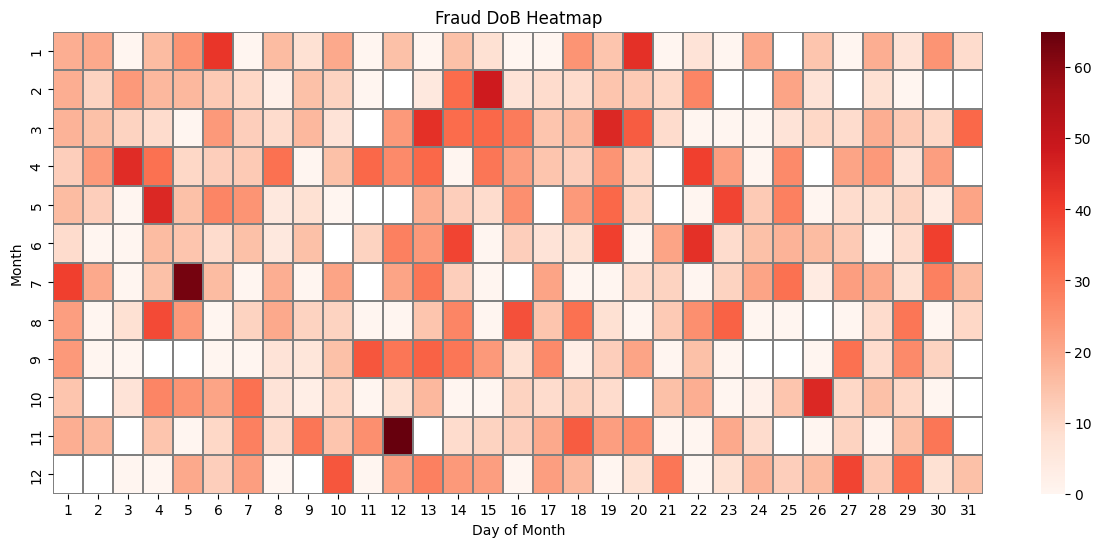

In [20]:
df_viz["dob"] = pd.to_datetime(df_viz["dob"])
df_viz["dob_year"] = df_viz["dob"].dt.year
df_viz["dob_month"] = df_viz["dob"].dt.month
df_viz["dob_day"] = df_viz["dob"].dt.day

fraud_dob = df_viz.groupby(["dob_month","dob_day"])["is_fraud"].sum().reset_index()

pivoted = fraud_dob.pivot(
    index="dob_month", columns="dob_day", values="is_fraud"
)

plt.figure(figsize=(15,6))
sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
plt.title(f"Fraud DoB Heatmap")
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.show()

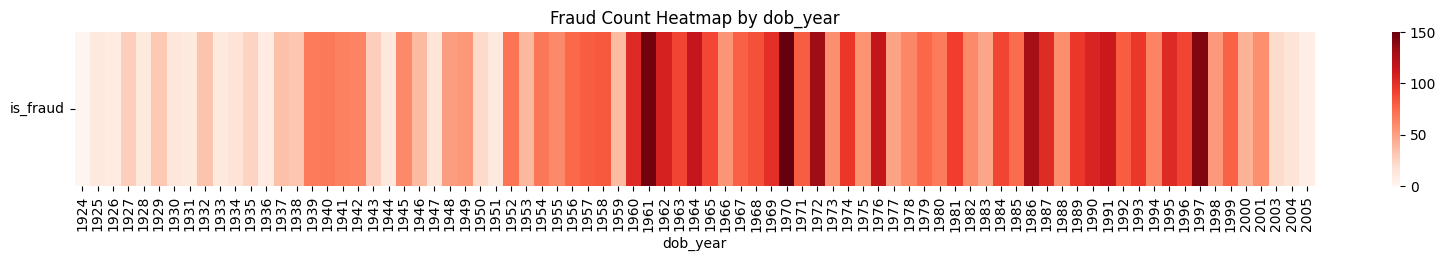

In [21]:
def feature_to_target(df, column):
    partition = df.groupby(column)["is_fraud"].sum().reset_index()

    # reshape into 1-row dataframe
    heatmap_data = partition.set_index(column).T

    plt.figure(figsize=(20, 2))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        annot=False,  # disable is_fraud count labels
        cbar=True
    )
    plt.title(f"Fraud Count Heatmap by {column}")
    plt.yticks(rotation=0)
    plt.show()

feature_to_target(df_viz, "dob_year")

## Calculate distance between merchants and customers

In [36]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return r * c

# Example usage with your DataFrame df
df_viz['distance_km'] = haversine_vectorized(
    df['lat'], df['long'], df['merch_lat'], df['merch_long']
)

In [37]:
df_viz["distance_km"].nunique()

895088

In [38]:
df["category"].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

## Concatenate customer_name

In [24]:
df_viz["customer_name"] = df_viz["first"].str.cat(df_viz["last"], sep='')

In [25]:
df_viz["customer_name"].nunique()

950

## Split job

In [22]:
def split_jobs(df, col="job"):
    # Split by comma → expand into lists
    job_splits = df[col].str.split(",")

    # Find maximum number of jobs in any row
    max_jobs = job_splits.map(len).max()

    # Create new DataFrame with expanded columns
    job_df = pd.DataFrame(job_splits.tolist(), index=df.index)

    # Rename columns as job_1, job_2, ...
    job_df = job_df.rename(columns={i: f"job_{i+1}" for i in range(max_jobs)})

    # Trim whitespace from each job string
    job_df = job_df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

    # Concatenate back with original DataFrame (optional)
    df_expanded = pd.concat([df, job_df], axis=1)

    return df_expanded

# Example usage
df_viz = split_jobs(df_viz, col="job")

In [39]:
df_viz.nunique()

,0
trans_date_trans_time,879517
cc_num,959
merchant,693
category,14
amt,45685
first,346
last,476
gender,2
street,959
city,876


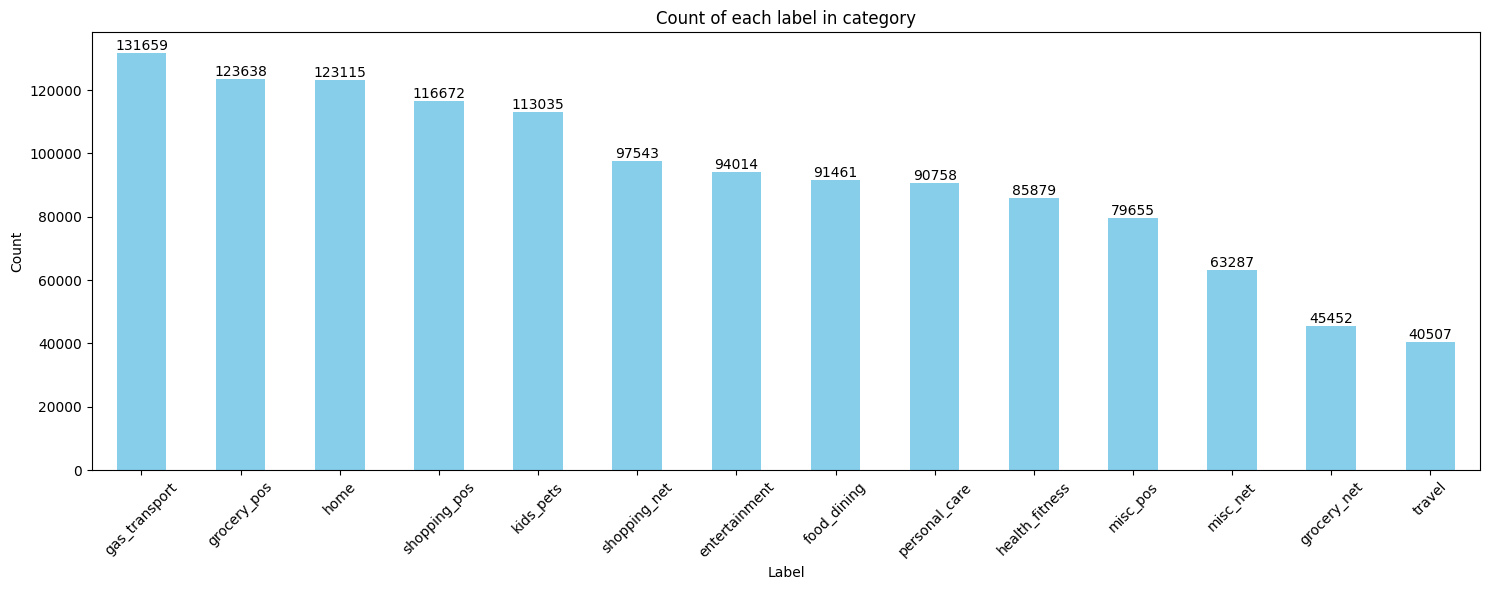

In [ ]:
cat_plot(df_viz, "category")

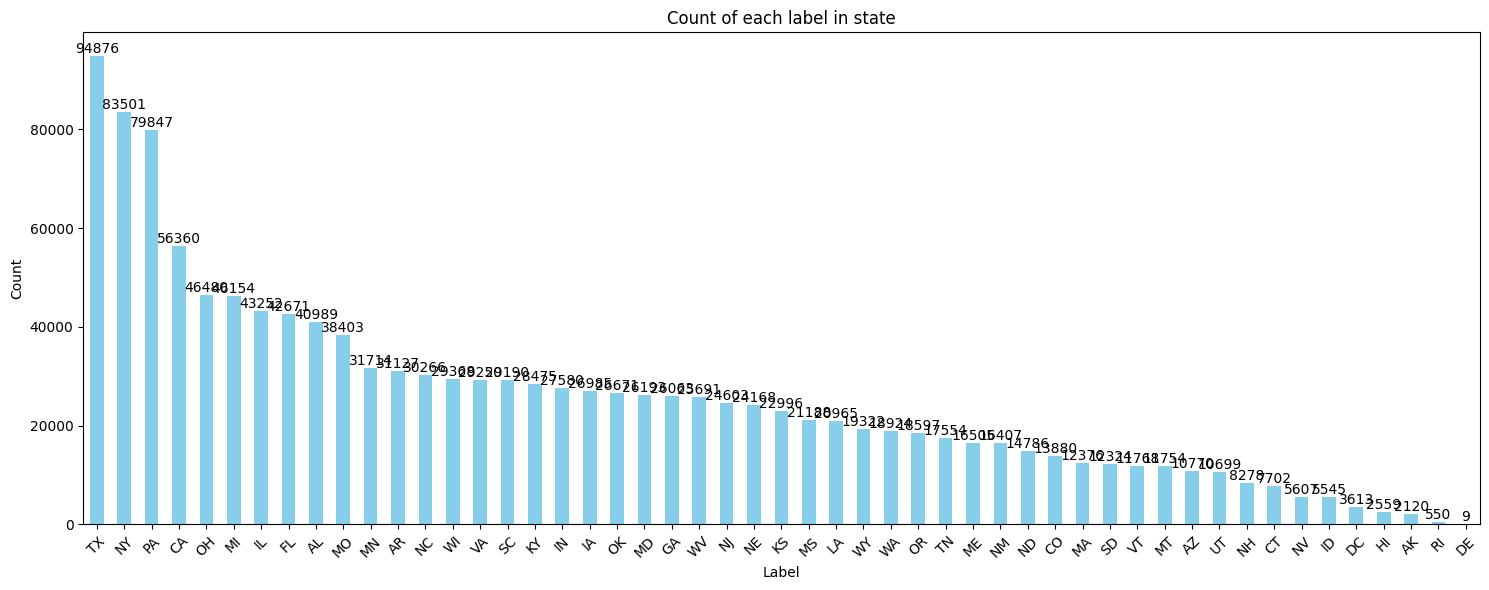

In [ ]:
cat_plot(df_viz, "state")

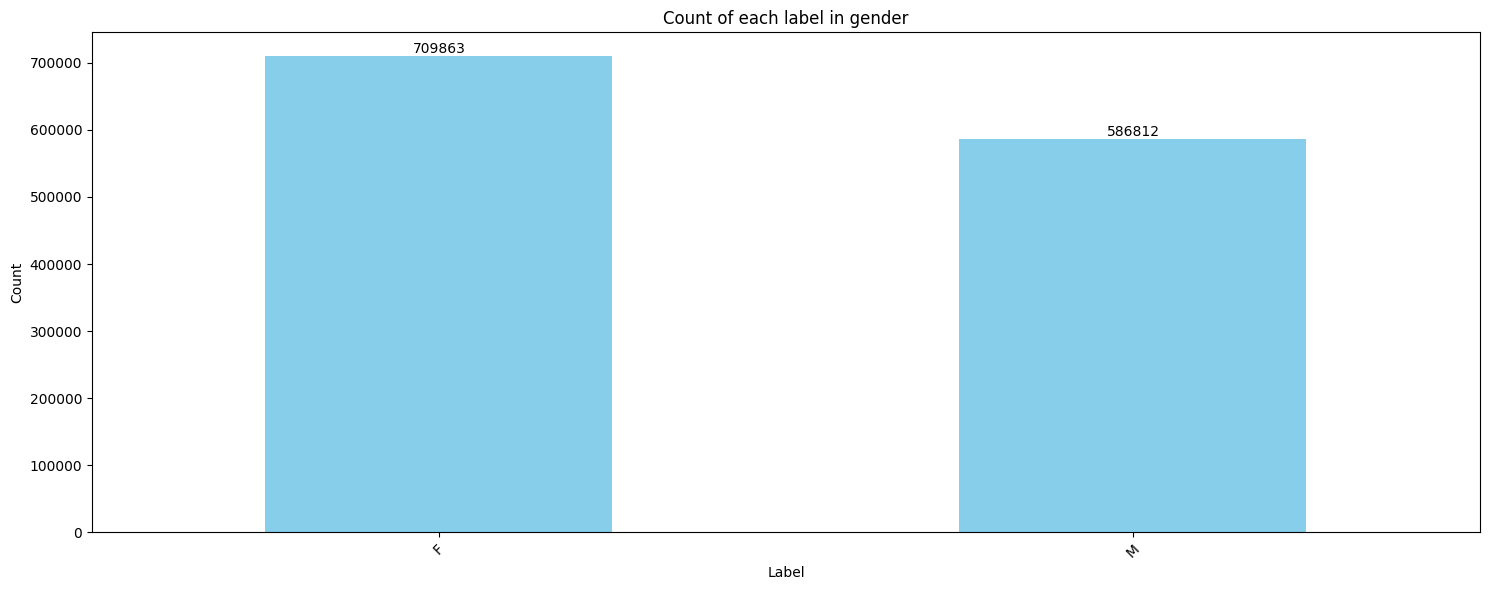

In [ ]:
cat_plot(df_viz, "gender")

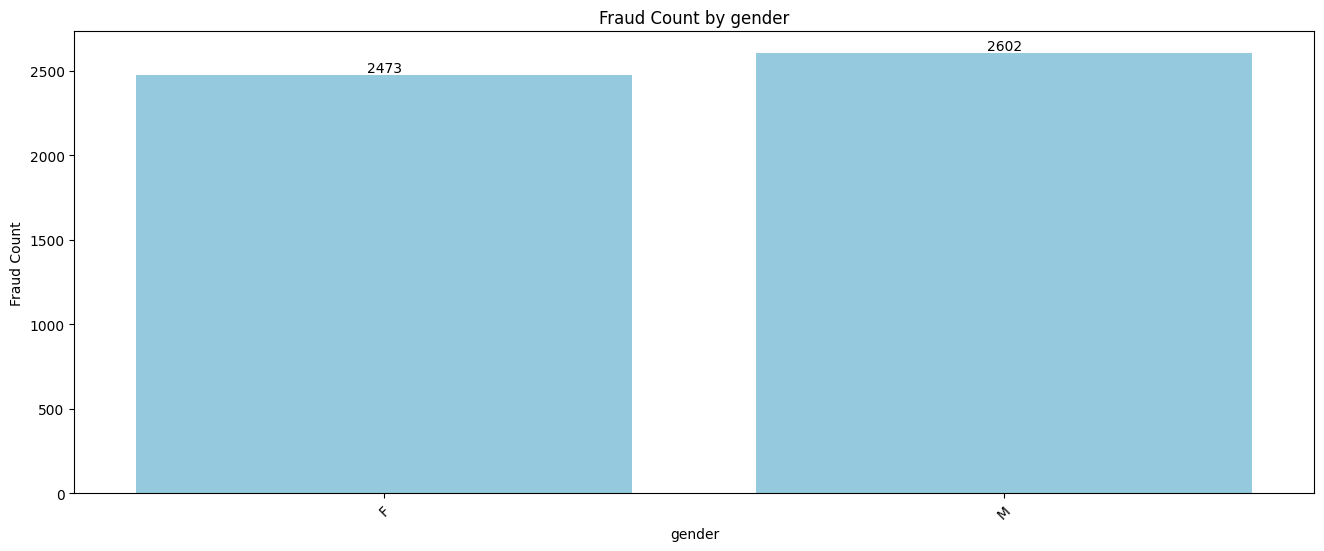

In [30]:
def fraud_countplot(df, column):
    # Count how many frauds per unique value in column
    fraud_counts = df.groupby(column)["is_fraud"].sum().reset_index()

    plt.figure(figsize=(16,6))
    ax = sns.barplot(
        data=fraud_counts,
        x=column,
        y="is_fraud",
        color="skyblue"   # fraud counts in red
    )

    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",      # label = fraud count
            (p.get_x() + p.get_width()/2, p.get_height()),  # position at top
            ha="center", va="bottom",
            fontsize=10, color="black", rotation=0
        )

    plt.title(f"Fraud Count by {column}")
    plt.ylabel("Fraud Count")
    plt.xticks(rotation=45)
    plt.show()

fraud_countplot(df_viz, "gender")

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from scipy.stats import chi2_contingency

# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x, y)
#     chi2 = chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
#     rcorr = r - ((r-1)**2)/(n-1)
#     kcorr = k - ((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# # Select categorical columns
# cat_cols = df.select_dtypes(include=["object"])

# # Encode to categorical (for correlation matrix loop)
# cat_encoded = cat_cols.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))

# # Compute Cramér’s V matrix
# corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
#                         index=cat_cols.columns, columns=cat_cols.columns)

# for c1 in cat_cols.columns:
#     for c2 in cat_cols.columns:
#         corr_cat.loc[c1, c2] = cramers_v(cat_encoded[c1], cat_encoded[c2])

# # Mask upper triangle
# mask = np.triu(np.ones_like(corr_cat, dtype=bool))

# plt.figure(figsize=(10,8))
# sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
# plt.title("Categorical Features Correlation (Cramér’s V)")
# plt.show()

## Numerical Correlation

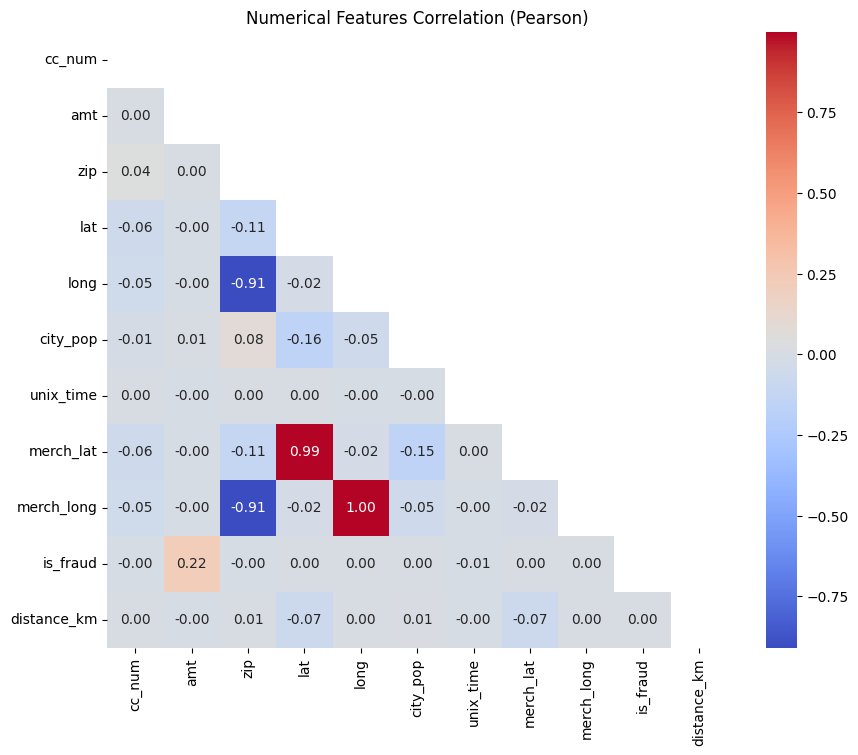

In [ ]:
num_cols = df_viz.select_dtypes(include=['int64', 'float64'])

# Pearson correlation
corr_num = num_cols.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_num, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(corr_num, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("Numerical Features Correlation (Pearson)")
plt.show()

## Categorical Correlation


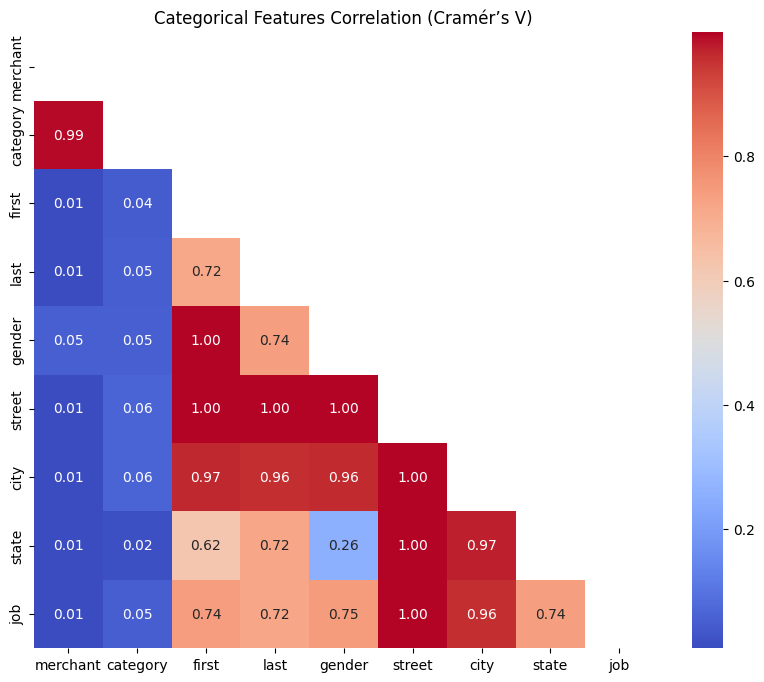

In [5]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Select categorical columns

#df = df.sample(frac=0.1, random_state=42) # Thay đổi fraction nếu máy m ko chạy full đc. Bỏ dòng này đi nếu chạy đc full
cat_cols = df.select_dtypes(include=["object"]).astype("category")
cat_cols = cat_cols.drop(["trans_date_trans_time", "dob","trans_num"], axis=1)

# Compute Cramér’s V matrix
corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
                        index=cat_cols.columns, columns=cat_cols.columns)

for c1 in cat_cols.columns:
    for c2 in cat_cols.columns:
        corr_cat.loc[c1, c2] = cramers_v(cat_cols[c1], cat_cols[c2])

# Mask upper triangle
mask = np.triu(np.ones_like(corr_cat, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("Categorical Features Correlation (Cramér’s V)")
plt.show()

In [27]:
def categorize_time_of_day(hour):
    if 22 <= hour or hour < 3:
        return 'Night'
    else:
        return 'Day'

df_viz['time_of_day'] = df_viz['hour'].apply(categorize_time_of_day)

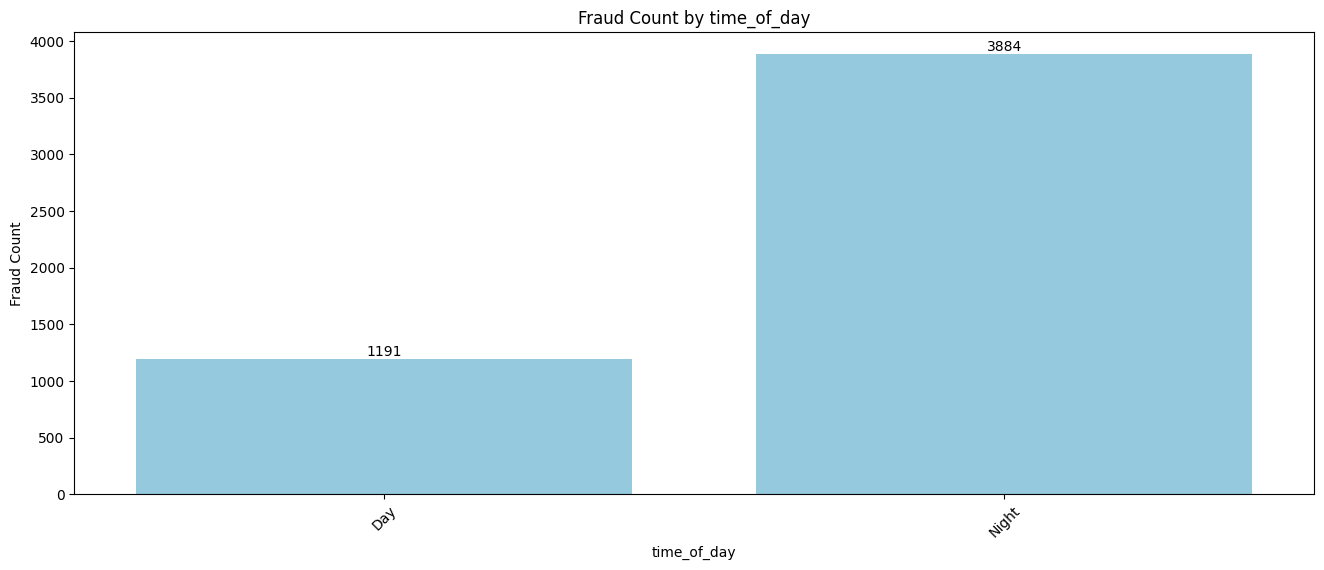

In [31]:
fraud_countplot(df_viz, "time_of_day")

In [32]:
df_viz['category'].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

## Offline vs online

### Define a function to categorize payment methods
Create a function that takes a row of the DataFrame as input and returns 'online' or 'offline' based on the 'category' and 'distance_km' values.


In [46]:
def categorize_payment_method(row):
    if row['category'].endswith('_net'):
        return 'online'
    elif row['category'].endswith('_pos'):
        return 'offline'
    else:
        if row['distance_km'] > 0.2:
            return 'online'
        else:
            return 'offline'

### Apply the function to create a new column
Apply the function to the DataFrame to create a new column named 'payment_method'.


In [47]:
df_viz['payment_method'] = df_viz.apply(categorize_payment_method, axis=1)

### Verify the new column


In [48]:
df_viz['payment_method'].value_counts()

,count
payment_method,
online,674353
offline,220735


### Visualize fraud by payment method



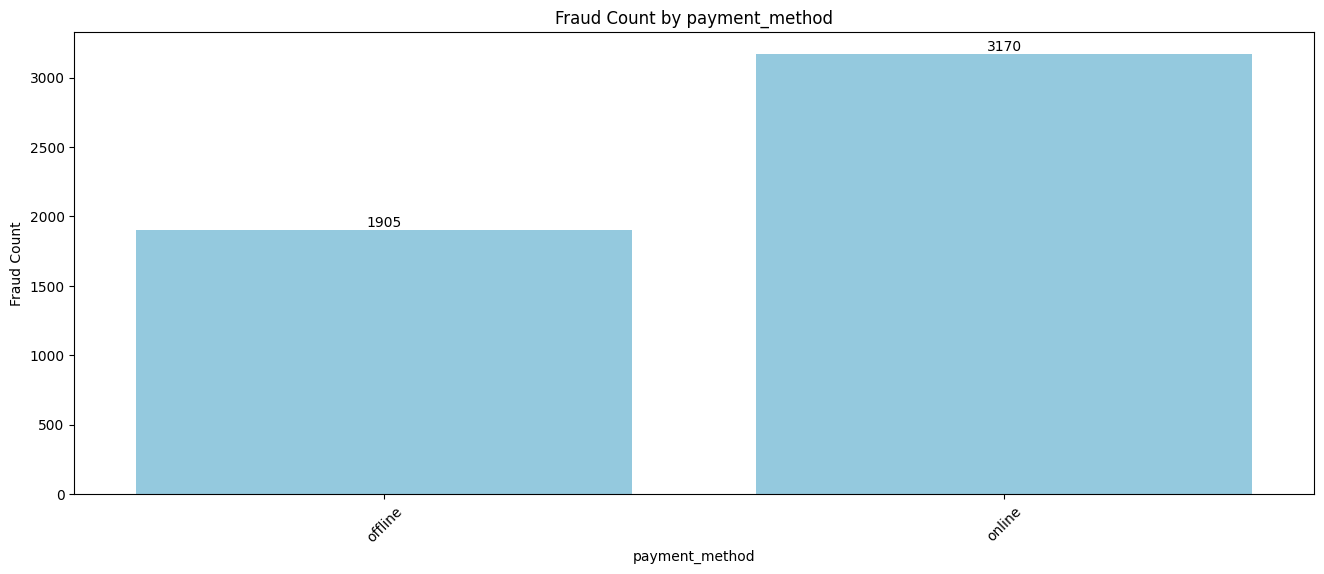

In [49]:
fraud_countplot(df_viz, "payment_method")

In [50]:
df_viz

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,month,day,hour,minute,second,dob_year,dob_month,dob_day,job_1,job_2,customer_name,time_of_day,distance_km,payment_method
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654.0,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0,2019,1,1,0,0,18,1988,3,9,Psychologist,counselling,JenniferBanks,Night,78.597568,online
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160.0,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0,2019,1,1,0,0,44,1978,6,21,Special educational needs teacher,None,StephanieGill,Night,30.212176,offline
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252.0,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0,2019,1,1,0,0,51,1962,1,19,Nature conservation officer,None,EdwardSanchez,Night,108.206083,online
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632.0,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0,2019,1,1,0,1,16,1967,1,12,Patent attorney,None,JeremyWhite,Night,95.673231,online
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433.0,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0,2019,1,1,0,3,6,1986,3,28,Dance movement psychotherapist,None,TylerGarcia,Night,77.556744,offline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895083,2019-12-25 14:35:48,3546674063249004,fraud_McKenzie-Huels,food_dining,10.62,Jordan,May,M,1626 Susan Course,Aledo,TX,76008.0,32.7004,-97.6039,13602.0,Optometrist,1984-07-05,bbd589c3400de51517e83c3dd8bfd3f1,1.356446e+09,32.206868,-97.327627,0.0,2019,12,25,14,35,48,1984,7,5,Optometrist,None,JordanMay,Day,60.692565,online
895084,2019-12-25 14:36:10,213174467670432,"fraud_Schiller, Blanda and Johnson",home,30.23,James,Bishop,M,7055 Fernandez Estates Apt. 676,Cecilton,MD,21913.0,39.4015,-75.8654,663.0,Podiatrist,1969-01-14,7f8ace7d126cc3687fb5e399487e6532,1.356446e+09,40.371404,-75.280860,0.0,2019,12,25,14,36,10,1969,1,14,Podiatrist,None,JamesBishop,Day,118.821287,online
895085,2019-12-25 14:36:14,4989847570577635369,"fraud_Armstrong, Walter and Gottlieb",food_dining,26.30,Vanessa,Anderson,F,21178 Brittney Locks,Prosperity,SC,29127.0,34.1832,-81.5324,8333.0,Archaeologist,1994-07-09,d920c9fad3f4c1cff612026bc5e9470b,1.356446e+09,33.363949,-80.603823,0.0,2019,12,25,14,36,14,1994,7,9,Archaeologist,None,VanessaAnderson,Day,125.158749,online
895086,2019-12-25 14:36:21,38947654498698,fraud_Bode-Rempel,kids_pets,7.54,Lori,Rodriguez,F,12087 Michael Light,Creola,OH,45622.0,39.3543,-82.5030,321.0,"Copywriter, advertising",1979-06-24,6ceae4cc2dfe785533f8432b32d7d655,1.356446e+09,38.833550,-81.687636,0.0,2019,12,25,14,36,21,1979,6,24,Copywriter,advertising,LoriRodriguez,Day,91.127228,online


In [53]:
df_viz[df_viz['category'].str.endswith('_pos')].head(10)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,month,day,hour,minute,second,dob_year,dob_month,dob_day,job_1,job_2,customer_name,time_of_day,distance_km,payment_method
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160.0,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0,2019,1,1,0,0,44,1978,6,21,Special educational needs teacher,None,StephanieGill,Night,30.212176,offline
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433.0,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0,2019,1,1,0,3,6,1986,3,28,Dance movement psychotherapist,None,TylerGarcia,Night,77.556744,offline
8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,Manor,PA,15665.0,40.3359,-79.6607,1472.0,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1.325376e+09,40.351813,-79.958146,0.0,2019,1,1,0,5,18,1941,3,7,Public affairs consultant,None,HeatherChase,Night,25.270494,offline
9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040.0,36.5220,-87.3490,151785.0,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1.325376e+09,37.179198,-87.485381,0.0,2019,1,1,0,6,1,1974,3,28,Pathologist,None,MelissaAguilar,Night,74.077750,offline
10,2019-01-01 00:06:23,4642894980163,fraud_Rutherford-Mertz,grocery_pos,24.74,Eddie,Mendez,M,1831 Faith View Suite 653,Clarinda,IA,51632.0,40.7491,-95.0380,7297.0,IT trainer,1990-07-13,d71c95ab6b7356dd74389d41df429c87,1.325376e+09,40.275891,-96.011548,0.0,2019,1,1,0,6,23,1990,7,13,IT trainer,None,EddieMendez,Night,97.683266,offline
12,2019-01-01 00:06:56,180042946491150,fraud_Lockman Ltd,grocery_pos,71.22,Charles,Robles,M,3337 Lisa Divide,Saint Petersburg,FL,33710.0,27.7898,-82.7243,341043.0,"Engineer, land",1989-02-28,c1d9a7ddb1e34639fe82758de97f4abf,1.325376e+09,27.630593,-82.308891,0.0,2019,1,1,0,6,56,1989,2,28,Engineer,land,CharlesRobles,Night,44.561080,offline
13,2019-01-01 00:07:27,5559857416065248,fraud_Kiehn Inc,grocery_pos,96.29,Jack,Hill,M,5916 Susan Bridge Apt. 939,Grenada,CA,96038.0,41.6125,-122.5258,589.0,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,1.325376e+09,41.657520,-122.230347,0.0,2019,1,1,0,7,27,1945,12,21,Systems analyst,None,JackHill,Night,25.059079,offline
14,2019-01-01 00:09:03,3514865930894695,fraud_Beier-Hyatt,shopping_pos,7.77,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325.0,32.9396,-105.8189,899.0,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,1.325377e+09,32.863258,-106.520205,0.0,2019,1,1,0,9,3,1967,8,30,Naval architect,None,ChristopherCastaneda,Night,66.021685,offline
17,2019-01-01 00:10:58,3565423334076143,fraud_Mayert Group,shopping_pos,341.67,Nathan,Thomas,M,4923 Campbell Pines Suite 717,Carlisle,IN,47838.0,38.9763,-87.3667,4081.0,Energy engineer,1938-03-15,f12cf52be2175703db789a4644c32f25,1.325377e+09,38.674491,-88.305767,0.0,2019,1,1,0,10,58,1938,3,15,Energy engineer,None,NathanThomas,Night,87.998950,offline
19,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208.0,40.6747,-74.2239,124967.0,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1.325377e+09,40.079588,-74.848087,0.0,2019,1,1,0,12,34,1980,12,21,Operational researcher,None,KennethRobinson,Night,84.702120,offline
